In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DB_PATH = Path("../data/duckdb/motorcycle.db")

# Use a single, consistent connection for this notebook only
con = duckdb.connect(str(DB_PATH), read_only=True)


In [2]:
con.execute("SHOW TABLES").fetchdf()


,name
0,dim_date
1,dim_date_keyed
2,dim_manufacturer
3,dim_manufacturer_keyed
4,dim_model
5,dim_model_keyed
6,dim_state
7,dim_state_keyed
8,fct_registrations
9,mart_market_share_monthly


Find the exact manufacturer strings for Royal Enfield

In [3]:
re_variants = con.execute("""
SELECT DISTINCT manufacturer
FROM vw_registrations
WHERE LOWER(manufacturer) LIKE '%eicher%'
   OR LOWER(manufacturer) LIKE '%enfield%'
ORDER BY manufacturer
""").fetchdf()

re_variants


,manufacturer
0,EICHER MOTERS (IND)
1,ENFIELD (IND)


3) Create a Royal Enfield-only view inside the notebook (no global views)
   
    We’ll not create vw_registrations_brand to avoid collisions.
    This view is only for this notebook session.

In [4]:
con.execute("DROP VIEW IF EXISTS vw_re")

con.execute("""
CREATE TEMP VIEW vw_re AS
SELECT
  date,
  year,
  month,
  year_month,
  state,
  manufacturer,
  trade_name,
  type_key,
  registrations_count,
  Object_Id,
  'Royal Enfield (Eicher Motors, India)' AS brand
FROM vw_registrations
WHERE LOWER(manufacturer) IN ('eicher motors (ind)', 'enfield (ind)')
""")


In [5]:
con.execute("SELECT COUNT(*) AS rows FROM vw_re").fetchdf()


,rows
0,264


Yearly growth + market share (Royal Enfield vs total market)

In [6]:
re_vs_market = con.execute("""
WITH market AS (
  SELECT year, SUM(registrations_count) AS total_market
  FROM vw_registrations
  GROUP BY 1
),
re AS (
  SELECT year, SUM(registrations_count) AS re_registrations
  FROM vw_re
  GROUP BY 1
)
SELECT
  m.year,
  COALESCE(r.re_registrations, 0) AS re_registrations,
  m.total_market,
  ROUND(100.0 * COALESCE(r.re_registrations, 0) / NULLIF(m.total_market, 0), 4) AS re_market_share_pct
FROM market m
LEFT JOIN re r USING (year)
ORDER BY m.year
""").fetchdf()

re_vs_market


,year,re_registrations,total_market,re_market_share_pct
0,2023,14803.0,4910141.0,0.3015
1,2024,17415.0,4987191.0,0.3492
2,2025,0.0,5056626.0,0.0000


Plot: Royal Enfield registrations (yearly)

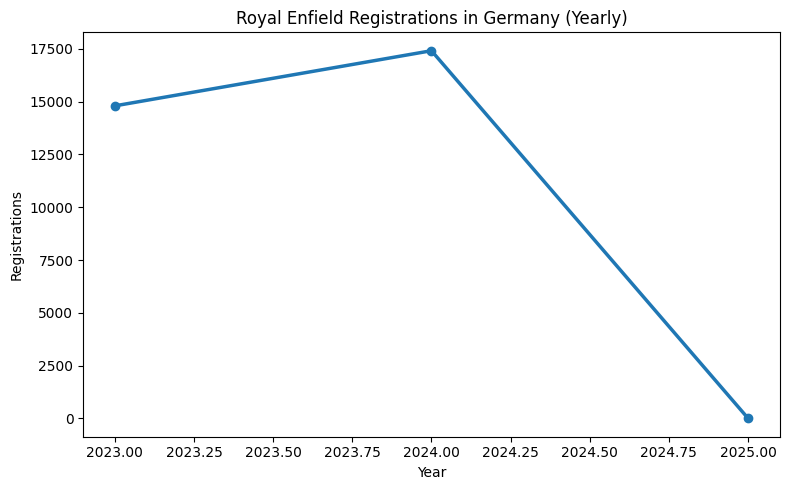

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(re_vs_market["year"], re_vs_market["re_registrations"], marker="o", linewidth=2.5)
plt.title("Royal Enfield Registrations in Germany (Yearly)")
plt.xlabel("Year")
plt.ylabel("Registrations")
plt.tight_layout()
plt.show()


Plot: Royal Enfield market share

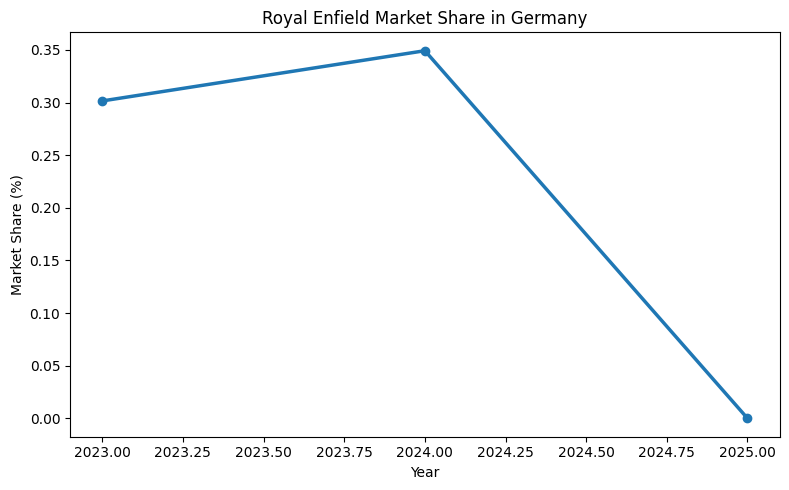

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(re_vs_market["year"], re_vs_market["re_market_share_pct"], marker="o", linewidth=2.5)
plt.title("Royal Enfield Market Share in Germany")
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.tight_layout()
plt.show()


In [9]:
re_by_state = con.execute("""
SELECT state, SUM(registrations_count) AS registrations
FROM vw_re
GROUP BY 1
ORDER BY registrations DESC
""").fetchdf()

re_by_state.head(15)


,state,registrations
0,Nordrhein-Westfalen,6246.0
1,Bayern,5291.0
2,Baden-Württemberg,4150.0
3,Niedersachsen,3362.0
4,Hessen,2677.0
5,Rheinland-Pfalz,2071.0
6,Sachsen,1714.0
7,Schleswig-Holstein,1351.0
8,Brandenburg,1090.0
9,Berlin,1086.0


In [10]:
re_models = con.execute("""
SELECT
  trade_name,
  type_key,
  SUM(registrations_count) AS registrations_count
FROM vw_re
GROUP BY 1,2
ORDER BY registrations_count DESC
""").fetchdf()

re_models.head(20)


,trade_name,type_key,registrations_count
0,SONSTIGE/NICHT GETYPT,,7776.0
1,"Signals 350,HNTR 350,Clas",AAG,6408.0
2,"Himalayan Scram 411,Himal",AAC,5283.0
3,"SG 6 1/2,SHOTGUN 6 1/2,SG",AAD,4186.0
4,"Continental GT 650,Interc",AAF,3738.0
5,"TB-X 500,Bullet Trials 50",AAE,2568.0
6,"Bullet EFI,Classic 500,Bu",AAA,2052.0
7,Continental GT,AAB,207.0


In [11]:
re_vs_market_clean = re_vs_market[re_vs_market["year"] < 2025].copy()
re_vs_market_clean


,year,re_registrations,total_market,re_market_share_pct
0,2023,14803.0,4910141.0,0.3015
1,2024,17415.0,4987191.0,0.3492


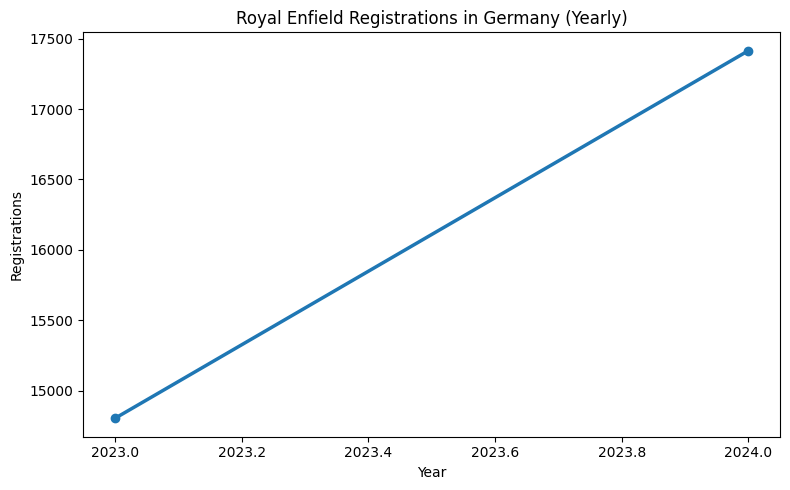

In [12]:
plot_df = re_vs_market[re_vs_market["year"] < 2025]

plt.figure(figsize=(8, 5))
plt.plot(plot_df["year"], plot_df["re_registrations"], marker="o", linewidth=2.5)
plt.title("Royal Enfield Registrations in Germany (Yearly)")
plt.xlabel("Year")
plt.ylabel("Registrations")
plt.tight_layout()
plt.show()


Chart 2 — Royal Enfield market share

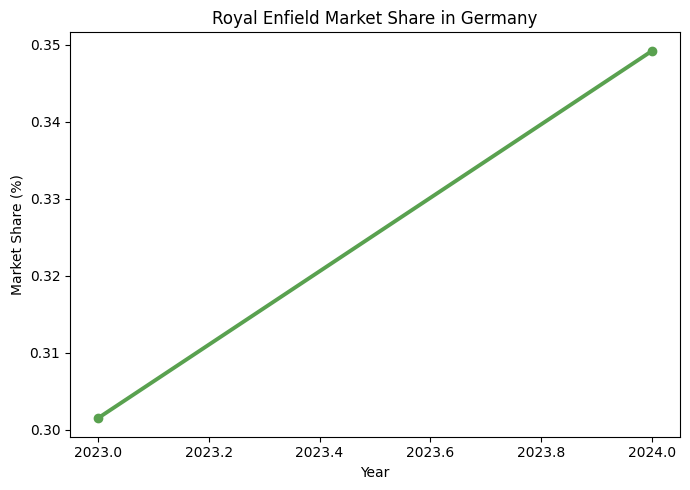

In [14]:
plt.figure(figsize=(7, 5))
plt.plot(
    plot_df["year"],
    plot_df["re_market_share_pct"],
    marker="o",
    linewidth=2.8,
    color="#59A14F"
)

plt.title("Royal Enfield Market Share in Germany")
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.tight_layout()
plt.show()


Chart 3 — YoY growth vs total market (key insight chart)

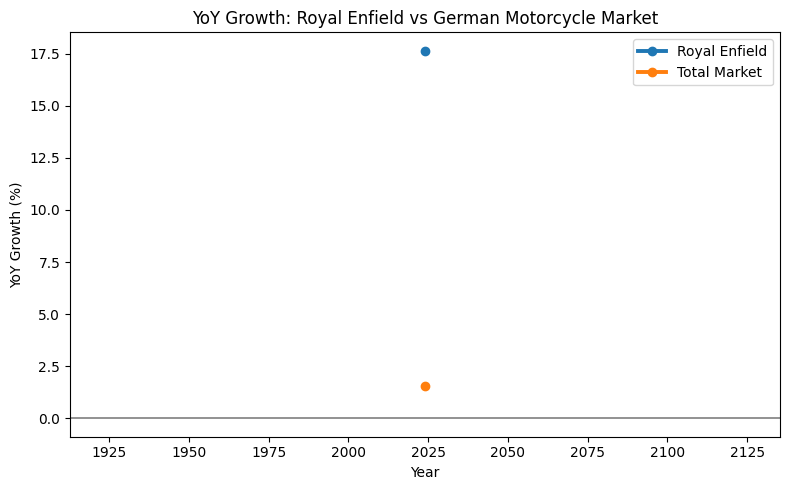

In [15]:
import pandas as pd

growth = plot_df.copy()
growth["re_yoy_pct"] = growth["re_registrations"].pct_change() * 100
growth["market_yoy_pct"] = growth["total_market"].pct_change() * 100

plt.figure(figsize=(8, 5))
plt.plot(growth["year"], growth["re_yoy_pct"], marker="o", linewidth=2.8, label="Royal Enfield")
plt.plot(growth["year"], growth["market_yoy_pct"], marker="o", linewidth=2.8, label="Total Market")

plt.axhline(0, linewidth=1.2, color="black", alpha=0.5)
plt.title("YoY Growth: Royal Enfield vs German Motorcycle Market")
plt.xlabel("Year")
plt.ylabel("YoY Growth (%)")
plt.legend()
plt.tight_layout()
plt.show()


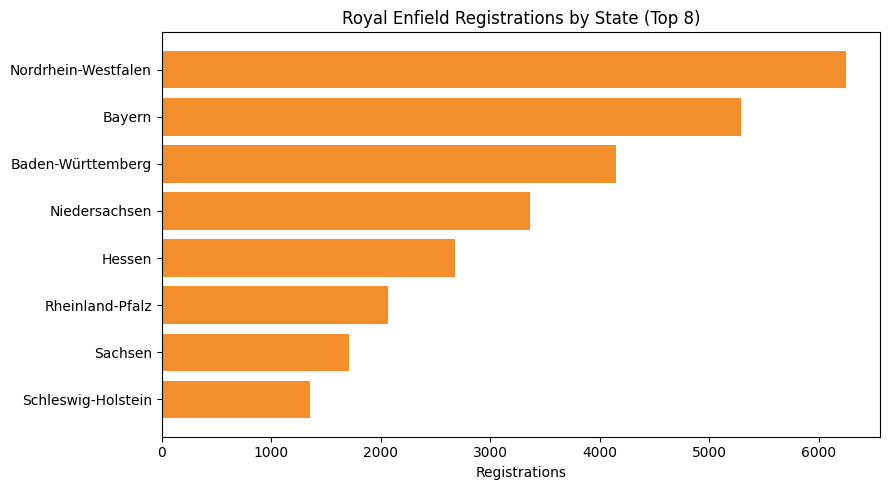

In [16]:
top_states = re_by_state.head(8).iloc[::-1]

plt.figure(figsize=(9, 5))
plt.barh(top_states["state"], top_states["registrations"], color="#F28E2B")
plt.title("Royal Enfield Registrations by State (Top 8)")
plt.xlabel("Registrations")
plt.tight_layout()
plt.show()


In [18]:
re_family = con.execute("""
SELECT
  CASE
    WHEN trade_name ILIKE '%SONSTIGE%' THEN 'Unclassified / Not typed'
    WHEN trade_name ILIKE '%Hunter%' 
      OR trade_name ILIKE '%Signals%' 
      OR trade_name ILIKE '%350%' 
      THEN '350cc Platform'
    WHEN trade_name ILIKE '%Himalayan%' 
      OR trade_name ILIKE '%Scram%' 
      THEN 'Adventure (411)'
    WHEN trade_name ILIKE '%Interceptor%' 
      OR trade_name ILIKE '%Continental%' 
      THEN '650 Twins'
    WHEN trade_name ILIKE '%Shotgun%' 
      OR trade_name ILIKE '%SG %' 
      OR trade_name ILIKE '%SG 6%' 
      THEN '650 Custom'
    WHEN trade_name ILIKE '%Bullet%' 
      OR trade_name ILIKE '%TB-%' 
      THEN 'Legacy 500cc'
    ELSE 'Other'
  END AS model_family,
  SUM(registrations_count) AS registrations
FROM vw_re
GROUP BY 1
ORDER BY registrations DESC
""").fetchdf()

re_family


,model_family,registrations
0,Unclassified / Not typed,7776.0
1,350cc Platform,6408.0
2,Adventure (411),5283.0
3,Legacy 500cc,4620.0
4,650 Custom,4186.0
5,650 Twins,3945.0


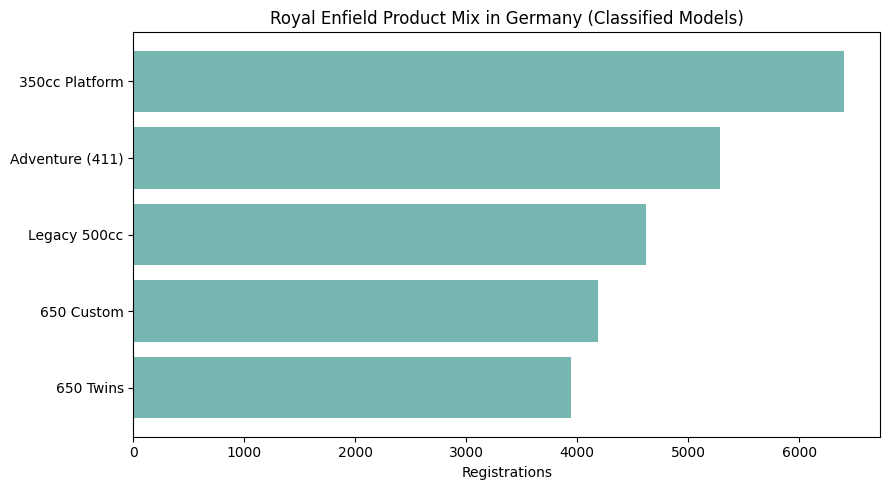

In [19]:
mix = re_family[re_family["model_family"] != "Unclassified / Not typed"]
mix = mix.sort_values("registrations")

plt.figure(figsize=(9, 5))
plt.barh(mix["model_family"], mix["registrations"], color="#76B7B2")
plt.title("Royal Enfield Product Mix in Germany (Classified Models)")
plt.xlabel("Registrations")
plt.tight_layout()
plt.show()


## Brand Case Study: Royal Enfield in Germany”

Royal Enfield (Eicher Motors, India) — Growth Analysis in Germany

Context & Objective:
This case study analyzes the growth and positioning of Royal Enfield, part of Eicher Motors (India), within the German motorcycle market.
The goal is to assess whether Royal Enfield is merely participating in a mature European market or actively gaining ground.
The German motorcycle market is characterized by:
High overall volumes
Low year-over-year growth
Strong incumbents (BMW, Japanese OEMs)
This makes it a good benchmark for evaluating brand expansion.

Data & Methodology:
- Manufacturer names appearing as “Eicher Motors (IND)” and “Enfield (IND)” were consolidated into a single canonical brand: Royal Enfield (Eicher Motors, India).
- Analysis focuses on 2023–2024 only.
- Data for 2025 represents a partial snapshot as of January 1st and was excluded from growth and share calculations.
- Registrations classified as “Sonstige / nicht getypt” were:
  -Included in total brand volume
  -Excluded from product-mix analysis
  
1️⃣ Absolute Growth in Germany
(Chart: Royal Enfield Registrations in Germany — Yearly)
Royal Enfield registrations increased from 14,803 units in 2023 to 17,415 units in 2024.
This represents a ~17.6% year-over-year increase, a notable rise in absolute volume for a non-European manufacturer in a mature market.

Key takeaway:
Royal Enfield is not stagnating at niche levels; it is scaling.


2️⃣ Market Share Expansion
(Chart: Royal Enfield Market Share in Germany)
While total motorcycle registrations in Germany grew only marginally (~1–2%), Royal Enfield’s market share increased from:
0.30% (2023) → 0.35% (2024)
This is a ~16% relative increase in market share within a single year.

Key takeaway:
Royal Enfield is growing faster than the market, indicating competitive gains rather than passive growth.


3️⃣ Growth vs Market Benchmark
(Chart: YoY Growth — Royal Enfield vs Total Market)
When benchmarked against the total German motorcycle market:
Royal Enfield shows double-digit YoY growth
The overall market remains largely flat

Key takeaway:
Royal Enfield is an outperformer in a low-growth environment — a strong signal of effective product-market fit.


4️⃣ Regional Concentration of Demand
(Chart: Royal Enfield Registrations by State — Top 8)
Registrations are concentrated in:
Bayern
Nordrhein-Westfalen
Baden-Württemberg
These regions align with:
Higher motorcycle ownership
Touring and lifestyle riding culture
Strong dealer ecosystems

Key takeaway:
Growth is geographically aligned with high-value motorcycle regions rather than being evenly dispersed.


5️⃣ Product Strategy & Model Mix
(Chart: Royal Enfield Product Mix in Germany — Classified Models)
Excluding unclassified records, Royal Enfield’s German volume is driven by:
Core Growth Segments
Modern 350cc platform (Hunter, Classic, Signals)
Adventure segment (Himalayan / Scram)
Brand-Building Segments
650cc twins (Interceptor / Continental GT)
650 custom platform (Shotgun / SG)
Declining / Legacy
Older 500cc UCE models

Key takeaway:
Royal Enfield’s German strategy emphasizes:
Accessible mid-capacity entry models
Strong lifestyle and adventure positioning
Halo products to support brand perception


6️⃣ Data Quality & Boundary Handling
A significant portion of registrations appears under “Sonstige / nicht getypt”, reflecting classification gaps in the source data rather than a distinct product line.
Additionally:
2025 data represents an incomplete boundary period and was intentionally excluded from trend analysis.

Key takeaway:
Analytical integrity was prioritized over forced completeness.

Executive Summary:
Royal Enfield (Eicher Motors, India) demonstrates above-market growth, rising market share, and a clear product strategy in Germany. Despite operating in a mature and highly competitive market, the brand is successfully expanding through a combination of accessible mid-capacity motorcycles and lifestyle-oriented positioning.

This pattern is consistent with a scalable European expansion strategy, rather than short-term volume chasing.


In [21]:
con.close()